# Inception

## 前期设置

#### 导入需要用到的包

In [1]:
import os
import tarfile
import time
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

#### 设置运算设备

若有可用的GPU设备，则设置变量device为'cuda'，否则为'cpu'。对之后代码中所有数据和模型参数使用.to(device)，就可以把它们转到我们想要的设备上。

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

#### 设置超参数

In [3]:
num_classes = 10  # 分类任务的类别数
batch_size = 32  # 每个小批次包含的样本数量
epochs = 5  # 训练周期数
lr = 1e-3  # 学习率

## 准备数据集

#### 导入数据集文件

若检测到未导入过数据集文件，则创建数据集存储路径，并将矩池云预置的数据集压缩文件解压至目标路径下。

In [4]:
if not os.path.exists('data/CIFAR-10'):  # 检测路径下是否已存在文件，若否，则执行以下代码
    os.mkdir('data/CIFAR-10')  # 创建数据存储路径，即data文件夹
    with tarfile.open('/public/keras_datasets/cifar-10-python.tar.gz') as tar:  # 矩池云上内置CIFAR-10数据集压缩文件的存储路径
        tar.extractall(path='data/CIFAR-10')  # 将数据集压缩文件解压，并保存至data文件夹中

#### 创建训练集、测试集

先使用torchvision.datasets中内置的CIFAR10类，将数据集文件转换为PyTorch中的数据集，并对其中的图片数据施加一定的预处理。接下来，使用DataLoader将数据集转化为分批次的数据读取器，可直接用于训练。

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 变形为Inception所需的输入形状（224 * 224）
    transforms.ToTensor(),  # 转换为tensor（注意，此处的tensor默认在CPU上储存）
])

In [6]:
trainset = torchvision.datasets.CIFAR10(root='data/CIFAR-10', train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)  # 进行打乱

testset = torchvision.datasets.CIFAR10(root='data/CIFAR-10', train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)  # 不进行打乱

#### 展示数据集样例

trainloader的格式比较特殊，直接使用trainloader[0]取其中第一个元素会报错。我们先将其转换为Python中的迭代器类型，再用next函数取其中第一个元素。

In [7]:
images, labels = next(iter(trainloader))  # 获取训练集第一个批次中的图片及相应标签
print(images.shape)
print(labels.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32])


查看训练集第一个批次中的图片。

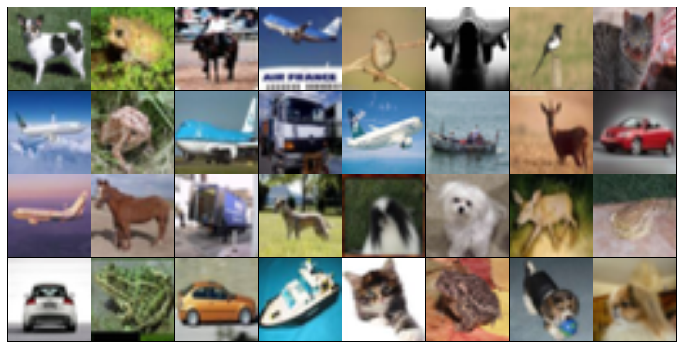

In [8]:
plt.figure(figsize=(12, 12))  # 设置画布大小
plt.axis('off')  # 隐藏坐标轴
plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))  # make_grid函数把多张图片一起显示，permute函数调换channel维的顺序
plt.show()

## 构建模型

继承PyTorch内置的nn.Module类，即可构建任意自己想要的模型。模型中还可以嵌套模型。

一个简单的示例如下：

In [9]:
class Add(nn.Module):  # 继承nn.Module类
    
    def __init__(self, add):
        super().__init__()  # 调用父类nn.Module的构造函数，为该类赋予一些特殊功能
        self.add = add
    
    def forward(self, x):  # forward方法是一个特殊的方法，它会在model(input)的时候被调用
        return x + self.add

In [10]:
a = torch.tensor(1)
model = Add(1)
b = model(a)  # 等同于b = model.forward(a)
b

tensor(2)

构建BasicConv2d模块，包含卷积、BN、ReLU三层，方便后续多处调用。

In [11]:
class BasicConv2d(nn.Module):  # 继承nn.Module类

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()  # 调用父类nn.Module的构造函数，为该类赋予一些特殊功能
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):  # forward方法是一个特殊的方法，它会在model(input)的时候被调用
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)  # inplace=True使运算在原tensor上进行，不产生新的tensor，节省内存

构建Inception模块，包含多个分支，最后把各个分支的输出拼接起来。用于组成完整的InceptionV1网络。

<img src="https://tva1.sinaimg.cn/large/008eGmZEgy1gngk582dg0j30x80hk40p.jpg" style="zoom:50%">

In [12]:
class InceptionV1Module(nn.Module):  # 继承nn.Module类
    
    def __init__(self, in_channels, out_channels_1x1, out_channels_3x3_reduce, out_channels_3x3, out_channels_5x5_reduce, out_channels_5x5, out_channels_pool):
        super().__init__()  # 调用父类nn.Module的构造函数，为该类赋予一些特殊功能
        
        # 1x1卷积分支
        self.branch_1x1 = BasicConv2d(in_channels, out_channels_1x1, kernel_size=1)
        
        # 3x3卷积分支
        self.branch_3x3 = nn.Sequential(
            BasicConv2d(in_channels, out_channels_3x3_reduce, kernel_size=1),
            BasicConv2d(out_channels_3x3_reduce, out_channels_3x3, kernel_size=3, padding=1),
        )
        
        # 5x5卷积分支
        self.branch_5x5 = nn.Sequential(
            BasicConv2d(in_channels, out_channels_5x5_reduce, kernel_size=1),
            BasicConv2d(out_channels_5x5_reduce, out_channels_5x5, kernel_size=5, padding=2),
        )
        
        # 池化分支
        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(in_channels, out_channels_pool, kernel_size=1),
        )
    
    def forward(self, x):  # forward方法是一个特殊的方法，它会在model(input)的时候被调用
        outputs_1x1 = self.branch_1x1(x)
        outputs_3x3 = self.branch_3x3(x)
        outputs_5x5 = self.branch_5x5(x)
        outputs_pool = self.branch_pool(x)
        outputs = [outputs_1x1, outputs_3x3, outputs_5x5, outputs_pool]
        return torch.cat(outputs, dim=1)  # 将各分支的输出拼接在一起

利用Inception模块搭建InceptionV1网络。

为方便理解，将InceptionV1网络分成五个阶段，用block_1~block_5表示。

<img src="https://tva1.sinaimg.cn/large/008eGmZEgy1gngk8fohjvj317c0u0dnl.jpg" style="zoom:50%">

In [13]:
class InceptionV1(nn.Module):  # 继承nn.Module类
    
    def __init__(self, num_classes):
        super().__init__()  # 调用父类nn.Module的构造函数，为该类赋予一些特殊功能
        
        self.block_1 = nn.Sequential(
            BasicConv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            BasicConv2d(64, 64, kernel_size=1),
            BasicConv2d(64, 192, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        
        self.block_2 = nn.Sequential(
            InceptionV1Module(192, 64, 96, 128, 16, 32, 32),  # 在类中嵌套使用另一个类，将其作为一个layer
            InceptionV1Module(256, 128, 128, 192, 32, 96, 64),   
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        
        self.block_3 = nn.Sequential(
            InceptionV1Module(480, 192, 96, 208, 16, 48, 64),
            InceptionV1Module(512, 160, 112, 224, 24, 64, 64),
            InceptionV1Module(512, 128, 128, 256, 24, 64, 64),
            InceptionV1Module(512, 112, 144, 288, 32, 64, 64),
            InceptionV1Module(528, 256, 160, 320, 32, 128, 128),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        
        self.block_4 = nn.Sequential(
            InceptionV1Module(832, 256, 160, 320, 32, 128, 128),
            InceptionV1Module(832, 384, 192, 384, 48, 128, 128),   
        )
        
        self.block_5 = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),  # 将特征图的长宽改变为1x1，对其中元素做平均
            nn.Dropout(p=0.4),
            nn.Flatten(start_dim=1),
            nn.Linear(1024, num_classes),
        )
    
    def forward(self, x):  # forward方法是一个特殊的方法，它会在model(input)的时候被调用
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)
        return x

In [14]:
model = InceptionV1(num_classes)
model.to(device)  # 将模型中所有参数tensor切换到GPU存储模式

model  # 展示模型的结构

InceptionV1(
  (block_1): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): BasicConv2d(
      (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): BasicConv2d(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): InceptionV1Module(
      (branch_1x1): BasicConv2d(
        (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    

## 模型训练

先定义几个训练中会用到的函数。

In [15]:
# 计算模型预测准确率
def accuracy(outputs, labels):
    preds = torch.max(outputs, dim=1)[1]  # 获取预测类别
    return torch.sum(preds == labels).item() / len(preds)  # 计算准确率

In [16]:
# 模型验证
def validate(model, testloader):
    val_loss = 0
    val_acc = 0
    
    model.eval()  # 模型切换到预测模式
    
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)  # 将tensor切换到GPU存储模式
        outputs = model(inputs)  # 计算模型输出
        
        loss = F.cross_entropy(outputs, labels)  # 计算交叉熵损失函数
        val_loss += loss.item()  # item方法提取出tensor中的数字
        
        acc = accuracy(outputs, labels)  # 计算准确率
        val_acc += acc
    
    model.train()  # 模型切换到训练模式
    
    val_loss /= len(testloader)  # 计算平均损失
    val_acc /= len(testloader)  # 计算平均准确率
    
    return val_loss, val_acc

In [17]:
# 打印训练结果
def print_log(epoch, train_time, train_loss, train_acc, val_loss, val_acc):
    print(f"Epoch [{epoch}/{epochs}], time: {train_time:.2f}s, loss: {train_loss:.4f}, acc: {train_acc:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}")

In [18]:
# 模型训练
def train(model, trainloader, testloader, epochs=1, lr=1e-3):
    model.train()  # 模型切换到训练模式
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # 设置优化器
    
    for epoch in range(1, epochs + 1):
        
        train_loss = 0
        train_acc = 0
        
        start = time.time()  # 记录本epoch开始时间
        
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)  # 将tensor切换到GPU存储模式

            optimizer.zero_grad()  # 将模型所有参数tensor的梯度变为0（否则之后计算的梯度会与先前存在的梯度叠加）

            outputs = model(inputs)  # 计算模型输出

            loss = F.cross_entropy(outputs, labels)  # 计算交叉熵损失函数
            train_loss += loss.item()  # item方法提取出tensor中的数字

            acc = accuracy(outputs, labels)  # 计算准确率
            train_acc += acc

            loss.backward()  # 调用PyTorch的autograd自动求导功能，计算loss相对于模型各参数的导数
            optimizer.step()  # 根据模型中各参数相对于loss的导数，以及指定的学习率，更新参数
        
        end = time.time()  # 记录本epoch结束时间
        train_time = end - start  # 计算本epoch的训练耗时
        
        train_loss /= len(trainloader)  # 计算平均损失
        train_acc /= len(trainloader)  # 计算平均准确率
        
        val_loss, val_acc = validate(model, testloader)  # 计算测试集上的损失函数和准确率
        
        print_log(epoch, train_time, train_loss, train_acc, val_loss, val_acc)  # 打印训练结果

输入参数epochs和lr，实施训练。

In [19]:
train(model, trainloader, testloader, epochs=epochs, lr=lr)  # 实施训练

Epoch [1/5], time: 163.77s, loss: 1.4546, acc: 0.4597, val_loss: 1.4036, val_acc: 0.5132
Epoch [2/5], time: 163.76s, loss: 0.9642, acc: 0.6582, val_loss: 0.9332, val_acc: 0.6765
Epoch [3/5], time: 163.86s, loss: 0.7397, acc: 0.7425, val_loss: 0.7280, val_acc: 0.7451
Epoch [4/5], time: 163.80s, loss: 0.6025, acc: 0.7928, val_loss: 0.5970, val_acc: 0.7946
Epoch [5/5], time: 163.73s, loss: 0.5177, acc: 0.8209, val_loss: 0.5484, val_acc: 0.8172


## 模型预测

从训练集中选取几张图片，使用模型做出预测，观察结果。

In [20]:
# 模型预测
def predict(model, inputs):
    model.eval()  # 模型切换到预测模式
    outputs = model(inputs.to(device))
    preds = torch.max(outputs, dim=1)[1]
    return preds

In [21]:
testiter = iter(testloader)

每次对迭代器testiter执行next，就会取出其下一个元素。因此，多次运行以下代码块，即可测试不同的图片。

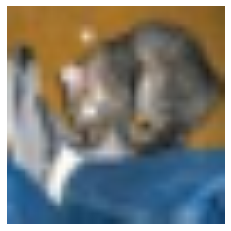

Prediction: cat


In [22]:
image = next(testiter)[0][0]
plt.axis('off')
plt.imshow(image.permute((1, 2, 0)))
plt.show()

pred = predict(model, image.unsqueeze(dim=0))  # 由于模型接受的输入shape为4维（第1维为batch_size），因此需要使用unsqueeze函数在图片前面加一维
print('Prediction:', testset.classes[pred])